In [1]:
# Importing the required libraries
from IPython.display import display
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import time
import easydict

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

from vae_lstm_model import VAE_LSTM

# Training device check-up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

writer = SummaryWriter()

# Defining DOE custom mape formula
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max(y_true))) * 100

Using device cuda:0


#### FETCHING AND PROCESSING CALENDER FEATURES

In [2]:
# Specifying the path of file
path= r"C:\Users\sashah8\OneDrive - North Carolina State University\Desktop\DOE\DOE_Q1\L5"

In [3]:
# Just for previewing the column name
data = pd.read_csv(os.path.join(path, "L5-dp.csv"))
data['utc'] = pd.to_datetime(data['utc'])
data['ept'] = pd.to_datetime(data['ept'])
print("Sample dataframe: ")
display(data.head(2))

Sample dataframe: 


,utc,ept,kw,tmpf
0,2017-01-01 05:00:00,2017-01-01 00:00:00,15984.0,48.0
1,2017-01-01 06:00:00,2017-01-01 01:00:00,15984.0,46.8


In [4]:
# Creating the calendar features
date = pd.DataFrame()
date['Month'] = data.ept.dt.month
date['Day'] = data.ept.dt.day
date['Weekday'] = data.ept.dt.weekday
date['Hour'] = data.ept.dt.hour
print("Sample dataframe: ")
display(date.head(2))
print("Available unique categories: ")
display(date.nunique())

Sample dataframe: 


,Month,Day,Weekday,Hour
0,1,1,6,0
1,1,1,6,1


Available unique categories: 


Month      12
Day        31
Weekday     7
Hour       24
dtype: int64

In [5]:
# One-hot encoding the categorical calendar features
date_enc = OneHotEncoder(sparse_output=False)
categorical_data = date_enc.fit_transform(date)
categorical_data

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
category_count = [len(x_len) for x_len in date_enc.categories_]
category_count

[12, 31, 7, 24]

#### PROCESSING CONTINUOUS FEATURES FOR ALL AVAILABLE ZONES

PROCESSING LOAD DATA

In [7]:
# Fetching and concatenating the data
load_ds = data[['kw']].copy().rename(columns={'kw': 'L5'})
load_ds = load_ds.add_suffix("_LOAD")
load_ds.tail(2)

,L5_LOAD
43822,13122.0
43823,12042.0


In [8]:
# Creating 1-day lag loads
load_lag_1 = load_ds.shift(24*2).add_suffix("_LAG1")
load_lag_1.tail(2)

,L5_LOAD_LAG1
43822,17712.0
43823,16740.0


In [9]:
# Creating 7-day lag loads
load_lag_7 = load_ds.shift(24*7).add_suffix("_LAG7")
load_lag_7.tail(2)

,L5_LOAD_LAG7
43822,14742.0
43823,14202.0


In [10]:
# Drop index for equalizing data
drop_idx = load_lag_7.dropna(axis= 0).index[0]
print("Drop data before: ", drop_idx)

Drop data before:  168


PROCESSING TEMPERATURE DATA

In [11]:
# Fetching and concatenating the data
temp_ds = data[['tmpf']].copy().rename(columns={'tmpf': 'L5'})
temp_ds = temp_ds.add_suffix("_A_TEMP")
temp_ds.tail(2)

,L5_A_TEMP
43822,63.5
43823,63.0


### PREPARING X AND Y PART

In [12]:
X_continuous = pd.concat([load_lag_1, load_lag_7, temp_ds], axis=1)
X_continuous = X_continuous.sort_index(axis=1)
X_continuous = X_continuous.iloc[drop_idx:].reset_index(drop=True)
X_continuous.tail(2)

,L5_A_TEMP,L5_LOAD_LAG1,L5_LOAD_LAG7
43654,63.5,17712.0,14742.0
43655,63.0,16740.0,14202.0


In [13]:
X_categorical = pd.DataFrame(categorical_data)
X_categorical = X_categorical.iloc[drop_idx:].reset_index(drop=True)
X_categorical.tail(2)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
43654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
43655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
Y = load_ds.copy()
Y = Y.sort_index(axis=1)
Y = Y.iloc[drop_idx:].reset_index(drop=True)
Y.tail(2)

,L5_LOAD
43654,13122.0
43655,12042.0


In [15]:
### SPLITTING THE DATA INTO TRAINING AND TESTING
# Setting the train-test split
ratio = 0.1
train_size, test_size = int(len(X_continuous)/24 * (1 - ratio) * 24), int(len(X_continuous)/24 * ratio * 24)
train_size, valid_size = int(train_size/24 * (1 - ratio) * 24), int(train_size/24 * ratio * 24)

print("Train samples: ", train_size, "\nValid samples: ", valid_size, "\nTest samples: ", test_size)

Train samples:  35361 
Valid samples:  3929 
Test samples:  4365


In [16]:
# Splitting the continuous data into training and test split
X_continuous_train, X_continuous_valid, X_continuous_test = X_continuous[:train_size], \
                                                            X_continuous[train_size:train_size+valid_size], \
                                                            X_continuous[train_size+valid_size:]
print("Train split of continuous data: ")
display(X_continuous_train.tail(2))

# Splitting the categorical data into training and test split
X_categorical_train, X_categorical_valid, X_categorical_test = X_categorical[:train_size], \
                                                               X_categorical[train_size:train_size+valid_size], \
                                                               X_categorical[train_size+valid_size:]
print("Train split of categorical data: ")
display(X_categorical_train.tail(2))

# Splitting the target into training and test split
Y_train, Y_valid, Y_test = Y[:train_size],  Y[train_size:train_size+valid_size], Y[train_size+valid_size:]
print("Train split of target data Y: ")
display(Y_train.tail(2))

Train split of continuous data: 


,L5_A_TEMP,L5_LOAD_LAG1,L5_LOAD_LAG7
35359,41.2,25542.0,27810.0
35360,44.8,24408.0,26406.0


Train split of categorical data: 


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
35359,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35360,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train split of target data Y: 


,L5_LOAD
35359,23058.0
35360,22410.0


In [17]:
print("Shape for continuous variable: ")
print(X_continuous_train.shape, X_continuous_valid.shape, X_continuous_test.shape, "\n")
print("Shape for categorical variable: ")
print(X_categorical_train.shape, X_categorical_valid.shape, X_categorical_test.shape, "\n")
print("Shape for target variable: ")
print(Y_train.shape, Y_valid.shape, Y_test.shape, "\n")
print("Does it cover entire training set: ", (X_continuous_train.shape[0] +
                                              X_continuous_valid.shape[0] +
                                              X_continuous_test.shape[0]) == len(X_continuous))

Shape for continuous variable: 
(35361, 3) (3929, 3) (4366, 3) 

Shape for categorical variable: 
(35361, 74) (3929, 74) (4366, 74) 

Shape for target variable: 
(35361, 1) (3929, 1) (4366, 1) 

Does it cover entire training set:  True


### SCALING THE DATA

In [18]:
# Scaling values using min-max scaler
mm_scaler_X = MinMaxScaler()
mm_scaler_Y = MinMaxScaler()

In [19]:
# Scaling continuous X train part
X_scaled_continuous_train = mm_scaler_X.fit_transform(X_continuous_train)

# Using the fit_scaler to scale the X valid part
X_scaled_continuous_valid = mm_scaler_X.transform(X_continuous_valid)

# Using the fit_scaler to scale the X test part
X_scaled_continuous_test = mm_scaler_X.transform(X_continuous_test)

print("Scaled continuous X train: ")
X_scaled_continuous_train

Scaled continuous X train: 


array([[0.18609407, 0.50535988, 0.39050536],
       [0.17484663, 0.51607963, 0.39050536],
       [0.16768916, 0.52986217, 0.38591118],
       ...,
       [0.44785276, 0.63552833, 0.69678407],
       [0.41104294, 0.66156202, 0.72588055],
       [0.44785276, 0.62940276, 0.68606432]])

In [20]:
# Scaling target Y train part
Y_scaled_train = mm_scaler_Y.fit_transform(Y_train)

# Using the fit_scaler to scale the Y valid part
Y_scaled_valid = mm_scaler_Y.transform(Y_valid)

# Using the fit_scaler to scale the Y test part
Y_scaled_test = mm_scaler_Y.transform(Y_test)

print("Scaled continuous Y train: ")
Y_scaled_train

Scaled continuous Y train: 


array([[0.69372129],
       [0.6906585 ],
       [0.69218989],
       ...,
       [0.57733538],
       [0.59111792],
       [0.57274119]])

In [21]:
# Converting a multivariate dataset into slices of samples
def split_data(calendar_data, x_data, y_data, n_steps, n_overlap):
    calendar, x, y = list(), list(), list()
    for i in range(0, len(x_data), n_steps-n_overlap):

        # Finding the split index
        end_idx = i + n_steps

        # Break the loop at end of dataset
        if end_idx > len(x_data):
            break

        # Appending the custom created samples with desired time-steps and features
        sample_calendar, sample_x, sample_y = calendar_data[i:end_idx, :], \
                                              x_data[i:end_idx, :], \
                                              y_data[i:end_idx, :]
        calendar.append(sample_calendar)
        x.append(sample_x)
        y.append(sample_y)

    return np.array(calendar), np.array(x), np.array(y)

In [22]:
num_steps = 24
train_num_overlap = 23
test_valid_num_overlap = 0

processed_data_train = split_data(calendar_data=X_categorical_train.to_numpy(),
                            x_data=X_scaled_continuous_train,
                            y_data=Y_scaled_train,
                            n_steps=num_steps, n_overlap=train_num_overlap)

processed_data_valid = split_data(calendar_data=X_categorical_valid.to_numpy(),
                            x_data=X_scaled_continuous_valid,
                            y_data=Y_scaled_valid,
                            n_steps=num_steps, n_overlap=test_valid_num_overlap)

processed_data_test = split_data(calendar_data=X_categorical_test.to_numpy(),
                            x_data=X_scaled_continuous_test,
                            y_data=Y_scaled_test,
                            n_steps=num_steps, n_overlap=test_valid_num_overlap)

print("Shape of the created samples for training: ", processed_data_train[2].shape)
print("Shape of the created samples for validation: ", processed_data_valid[2].shape)
print("Shape of the created samples for testing: ", processed_data_test[2].shape)

Shape of the created samples for training:  (35338, 24, 1)
Shape of the created samples for validation:  (163, 24, 1)
Shape of the created samples for testing:  (181, 24, 1)


In [23]:
## Sample check for sanity
print("First sample: \n")
processed_data_train[1][-1]

First sample: 



array([[0.35787321, 0.42266462, 0.61715161],
       [0.42535787, 0.36140888, 0.61408882],
       [0.48773006, 0.32771822, 0.60183767],
       [0.51431493, 0.30168453, 0.59264931],
       [0.54294479, 0.26952527, 0.56049005],
       [0.56952965, 0.26339969, 0.51607963],
       [0.57259714, 0.28943338, 0.52526799],
       [0.56748466, 0.35834609, 0.55130168],
       [0.54907975, 0.42725881, 0.6202144 ],
       [0.48977505, 0.46094946, 0.64931087],
       [0.48466258, 0.47013783, 0.66156202],
       [0.46830266, 0.47779479, 0.63705972],
       [0.47137014, 0.47779479, 0.6202144 ],
       [0.4601227 , 0.46860643, 0.60183767],
       [0.46216769, 0.48698315, 0.59111792],
       [0.44989775, 0.4992343 , 0.5941807 ],
       [0.44580777, 0.52833078, 0.60030628],
       [0.4591002 , 0.52986217, 0.61408882],
       [0.46421268, 0.53751914, 0.60796325],
       [0.4601227 , 0.55742726, 0.6202144 ],
       [0.45705521, 0.59724349, 0.65084227],
       [0.44785276, 0.63552833, 0.69678407],
       [0.

In [24]:
print("Second sample: \n")
processed_data_train[1][1]

Second sample: 



array([[0.17484663, 0.51607963, 0.39050536],
       [0.16768916, 0.52986217, 0.38591118],
       [0.16257669, 0.52067381, 0.37212864],
       [0.15644172, 0.54517611, 0.36906585],
       [0.14723926, 0.58346095, 0.37212864],
       [0.14621677, 0.63705972, 0.38284839],
       [0.14621677, 0.66003063, 0.39203675],
       [0.14621677, 0.63859112, 0.4042879 ],
       [0.16564417, 0.61102603, 0.41500766],
       [0.17484663, 0.59724349, 0.4042879 ],
       [0.19222904, 0.59724349, 0.39816233],
       [0.20449898, 0.57886677, 0.39663093],
       [0.2208589 , 0.58039816, 0.3797856 ],
       [0.23415133, 0.5957121 , 0.36447167],
       [0.24539877, 0.59111792, 0.37059724],
       [0.24744376, 0.60336907, 0.37825421],
       [0.23210634, 0.63399694, 0.40122511],
       [0.18813906, 0.63859112, 0.40122511],
       [0.18813906, 0.64624809, 0.39356815],
       [0.15132924, 0.6431853 , 0.38897397],
       [0.1400818 , 0.62787136, 0.37519142],
       [0.12167689, 0.59877489, 0.3568147 ],
       [0.

In [25]:
# Dividing the sampled data - training
categorical_samples_training = torch.Tensor(processed_data_train[0])
continuous_samples_training = torch.Tensor(processed_data_train[1])
target_samples_training = torch.Tensor(processed_data_train[2])

# Dividing the sampled data - validation
categorical_samples_validation = torch.Tensor(processed_data_valid[0])
continuous_samples_validation = torch.Tensor(processed_data_valid[1])
target_samples_validation = torch.Tensor(processed_data_valid[2])

# Dividing the sampled data - testing
categorical_samples_testing = torch.Tensor(processed_data_test[0])
continuous_samples_testing = torch.Tensor(processed_data_test[1])
target_samples_testing = torch.Tensor(processed_data_test[2])

In [26]:
print("Shape of categorical samples - training: ", categorical_samples_training.shape)
print("Shape of continuous samples - training: ", continuous_samples_training.shape)
print("Shape of target samples - training: ", target_samples_training.shape)
print("\n")
print("Shape of categorical samples - validation: ", categorical_samples_validation.shape)
print("Shape of continuous samples - validation: ", continuous_samples_validation.shape)
print("Shape of target samples - validation: ", target_samples_validation.shape)
print("\n")
print("Shape of categorical samples - testing: ", categorical_samples_testing.shape)
print("Shape of continuous samples - testing: ", continuous_samples_testing.shape)
print("Shape of target samples - testing: ", target_samples_testing.shape)

Shape of categorical samples - training:  torch.Size([35338, 24, 74])
Shape of continuous samples - training:  torch.Size([35338, 24, 3])
Shape of target samples - training:  torch.Size([35338, 24, 1])


Shape of categorical samples - validation:  torch.Size([163, 24, 74])
Shape of continuous samples - validation:  torch.Size([163, 24, 3])
Shape of target samples - validation:  torch.Size([163, 24, 1])


Shape of categorical samples - testing:  torch.Size([181, 24, 74])
Shape of continuous samples - testing:  torch.Size([181, 24, 3])
Shape of target samples - testing:  torch.Size([181, 24, 1])


### CREATING DATALOADER

In [27]:
BATCH_SIZE = 64

In [28]:
class TimeSeriesLoader(Dataset):
    def __init__(self, categorical, continuous, target):
        self.categorical, self.continuous, self.target = categorical, continuous, target

    def __len__(self):
        return len(self.categorical)

    def __getitem__(self, idx):
        return self.categorical[idx], self.continuous[idx], self.target[idx]

In [29]:
train_dataset = TimeSeriesLoader(categorical_samples_training,
                                 continuous_samples_training,
                                 target_samples_training)

valid_dataset = TimeSeriesLoader(categorical_samples_validation,
                                 continuous_samples_validation,
                                 target_samples_validation)

test_dataset = TimeSeriesLoader(categorical_samples_testing,
                                continuous_samples_testing,
                                target_samples_testing)

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [31]:
print("Number of batches in train dataloader: ", len(train_dataloader))
print("Number of batches in valid dataloader: ", len(valid_dataloader))
print("Number of batches in test dataloader: ", len(test_dataloader))

Number of batches in train dataloader:  553
Number of batches in valid dataloader:  3
Number of batches in test dataloader:  3


In [32]:
categorical_var_shape = train_dataloader.dataset.categorical.shape
continuous_var_shape = train_dataloader.dataset.continuous.shape
target_var_shape = train_dataloader.dataset.target.shape

print("Shape of categorical variables: ", categorical_var_shape)
print("Shape of continuous variables: ", continuous_var_shape)
print("Shape of target variables: ", target_var_shape)

Shape of categorical variables:  torch.Size([35338, 24, 74])
Shape of continuous variables:  torch.Size([35338, 24, 3])
Shape of target variables:  torch.Size([35338, 24, 1])


In [33]:
# Specifying number of zones and features per zone
num_zones = target_var_shape[2]
num_zone_features = int(continuous_var_shape[2] / target_var_shape[2])
print("Number of zones: ", num_zones)
print("Number of features per zone: ", num_zone_features)

Number of zones:  1
Number of features per zone:  3


## DEFINING MODEL ARCHITECTURE

In [34]:
args = easydict.EasyDict(
        {
            "device": torch.device("cuda")
            if torch.cuda.is_available()
            else torch.device("cpu"),
            "input_size": 3,
            "hidden_size": 2048,
            "latent_size": 1024,
            "output_size": 3,
            "learning_rate": 0.001,
            "max_iter": 1000,
        }
    )

input_size = args.input_size
hidden_size = args.hidden_size
latent_size = args.latent_size
output_size = args.output_size

In [35]:
def init_weights(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.kaiming_uniform_(model.weight, nonlinearity='relu')
        model.bias.data.fill_(0.01)

def save_checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def load_from_checkpoint(model, filename):
    model.load_state_dict(torch.load(filename))
    return model

In [36]:
# Define LSTM-based VAE model
vae_lstm_1 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)

In [37]:
# Defining optimizers
opt = torch.optim.Adam(list(vae_lstm_1.parameters()), lr=args.learning_rate)

In [38]:
def train(*models, optimizer, train_loader):

    model_1 = models[0]

    model_1.train()

    # Resetting the calculated gradients
    optimizer.zero_grad()

    train_iterator = tqdm(
        enumerate(train_loader), total=len(train_loader), desc="training"
    )

    for i, (categorical_var, continuous_var, target_var) in train_iterator:

        zone_1 = continuous_var[:, :, 0:3].to(device)

        m_loss_1, recon_x_1, info_1 = model_1(zone_1)

        # Resetting the calculated gradients
        optimizer.zero_grad()

        # Calculating the gradients for backprop
        m_loss_1.mean().backward()

        # Performing backprop step
        optimizer.step()

        train_iterator.set_postfix({"train_loss_1": float(m_loss_1.mean())})

    writer.add_scalar("train_loss_1", float(m_loss_1.mean()), epoch)

    train_loss = (
        m_loss_1.mean(),
    )

    return train_loss, model_1

In [39]:
def valid_or_test(*models, data_loader, mode):

    model_1 = models[0]

    model_1.eval()

    eval_loss_1 = 0

    orig_append_1, pred_append_1 = list(), list()

    if mode == "test":
        valid_or_test_iterator = tqdm(
            enumerate(data_loader), total=len(data_loader), desc="testing"
        )
    else:
        valid_or_test_iterator = tqdm(
            enumerate(data_loader), total=len(data_loader), desc="validation"
        )

    with torch.no_grad():
        for i, (categorical_var, continuous_var, target_var) in valid_or_test_iterator:

            zone_1 = continuous_var[:, :, 0:3].to(device)

            m_loss_1, recon_x_1, info_1 = model_1(zone_1)

            eval_loss_1 += m_loss_1.mean().item()

            valid_or_test_iterator.set_postfix({"eval_loss_1": float(m_loss_1.mean())})

            if mode == "test":

                orig_data_1 = zone_1.cpu().detach().numpy().reshape(-1, 3)
                pred_data_1 = recon_x_1.cpu().detach().numpy().reshape(-1, 3)

                orig_append_1.append(orig_data_1)
                pred_append_1.append(pred_data_1)

    eval_loss_1 = eval_loss_1 / len(data_loader)
    writer.add_scalar("eval_loss_1", float(eval_loss_1))

    print("Evaluation Score 1 : [{}]".format(eval_loss_1))
    print("\n")

    valid_loss = (
        eval_loss_1
    )

    # In test mode, return the true and predicted data for evaluation on hold-out test set
    if mode == "test":

        # Concatenating all the appended data
        orig_append_1 = pd.DataFrame(np.concatenate(orig_append_1))
        pred_append_1 = pd.DataFrame(np.concatenate(pred_append_1))

        return orig_append_1, pred_append_1

    # In valid mode, return the validation losses for early stopping
    else:
        return valid_loss

In [40]:
# The parameters for early stopping
early_stop_patience = 5

lowest_loss_1 = np.inf
lowest_loss_epoch_1 = -1

model_train_flag_1 = False

In [41]:
start_time = time.time()

# Train the VAE model
for epoch in range(200):
    print('Epoch', epoch + 1)

    train_losses, \
    trained_model_1 = train(vae_lstm_1, optimizer=opt, train_loader=train_dataloader)

    valid_losses = valid_or_test(trained_model_1, data_loader=valid_dataloader, mode="valid")

    # For model 1
    if (valid_losses < lowest_loss_1) and (model_train_flag_1 == False):
        lowest_loss_1 = valid_losses
        lowest_loss_epoch_1 = epoch
        save_checkpoint(trained_model_1, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_1.pth"))

    elif epoch - lowest_loss_epoch_1 > early_stop_patience:
        print("Individual model stopped training early at epoch {}".format(epoch))
        model_train_flag_1 = True
        break

end_time = time.time()

total_time = end_time - start_time
print("\nTotal time of training: {} hours".format(total_time/3600))

Epoch 1


validation: 100%|██████████| 3/3 [00:00<00:00, 43.48it/s, eval_loss_1=0.0305]


Evaluation Score 1 : [0.023586761206388474]


Epoch 2


validation: 100%|██████████| 3/3 [00:00<00:00, 44.12it/s, eval_loss_1=0.0158]


Evaluation Score 1 : [0.01788500789552927]


Epoch 3


validation: 100%|██████████| 3/3 [00:00<00:00, 45.10it/s, eval_loss_1=0.0226]


Evaluation Score 1 : [0.02044626045972109]


Epoch 4


validation: 100%|██████████| 3/3 [00:00<00:00, 46.15it/s, eval_loss_1=0.0139]


Evaluation Score 1 : [0.012638770664731661]


Epoch 5


validation: 100%|██████████| 3/3 [00:00<00:00, 45.45it/s, eval_loss_1=0.0126]


Evaluation Score 1 : [0.010435953425864378]


Epoch 6


validation: 100%|██████████| 3/3 [00:00<00:00, 44.12it/s, eval_loss_1=0.0119]


Evaluation Score 1 : [0.00904497504234314]


Epoch 7


validation: 100%|██████████| 3/3 [00:00<00:00, 46.15it/s, eval_loss_1=0.00979]


Evaluation Score 1 : [0.008688418194651604]


Epoch 8


validation: 100%|██████████| 3/3 [00:00<00:00, 43.48it/s, eval_loss_1=0.00623]


Evaluation Score 1 : [0.00588007861127456]


Epoch 9


validation: 100%|██████████| 3/3 [00:00<00:00, 44.78it/s, eval_loss_1=0.00489]


Evaluation Score 1 : [0.005187152264018853]


Epoch 10


validation: 100%|██████████| 3/3 [00:00<00:00, 45.46it/s, eval_loss_1=0.00284]


Evaluation Score 1 : [0.003798134004076322]


Epoch 11


validation: 100%|██████████| 3/3 [00:00<00:00, 46.15it/s, eval_loss_1=0.00441]


Evaluation Score 1 : [0.00528388066838185]


Epoch 12


validation: 100%|██████████| 3/3 [00:00<00:00, 44.78it/s, eval_loss_1=0.00287]


Evaluation Score 1 : [0.0033472244006892047]


Epoch 13


validation: 100%|██████████| 3/3 [00:00<00:00, 43.48it/s, eval_loss_1=0.00153]


Evaluation Score 1 : [0.0022398902413745723]


Epoch 14


validation: 100%|██████████| 3/3 [00:00<00:00, 45.80it/s, eval_loss_1=0.00292]


Evaluation Score 1 : [0.0037821844841043153]


Epoch 15


validation: 100%|██████████| 3/3 [00:00<00:00, 47.62it/s, eval_loss_1=0.00293]


Evaluation Score 1 : [0.003414043535788854]


Epoch 16


validation: 100%|██████████| 3/3 [00:00<00:00, 45.46it/s, eval_loss_1=0.00155]


Evaluation Score 1 : [0.0016912942907462518]


Epoch 17


validation: 100%|██████████| 3/3 [00:00<00:00, 51.72it/s, eval_loss_1=0.00154]


Evaluation Score 1 : [0.0016345295977468293]


Epoch 18


validation: 100%|██████████| 3/3 [00:00<00:00, 45.80it/s, eval_loss_1=0.0011]


Evaluation Score 1 : [0.0011718216507385175]


Epoch 19


validation: 100%|██████████| 3/3 [00:00<00:00, 45.11it/s, eval_loss_1=0.00234]


Evaluation Score 1 : [0.002176912617869675]


Epoch 20


validation: 100%|██████████| 3/3 [00:00<00:00, 45.11it/s, eval_loss_1=0.000851]


Evaluation Score 1 : [0.0010297967431445916]


Epoch 21


validation: 100%|██████████| 3/3 [00:00<00:00, 38.46it/s, eval_loss_1=0.00109]


Evaluation Score 1 : [0.0010752760184307892]


Epoch 22


validation: 100%|██████████| 3/3 [00:00<00:00, 46.88it/s, eval_loss_1=0.00115]


Evaluation Score 1 : [0.0010276792648558815]


Epoch 23


validation: 100%|██████████| 3/3 [00:00<00:00, 46.15it/s, eval_loss_1=0.000765]


Evaluation Score 1 : [0.0007459006543892125]


Epoch 24


validation: 100%|██████████| 3/3 [00:00<00:00, 46.15it/s, eval_loss_1=0.00201]


Evaluation Score 1 : [0.0018700349222247799]


Epoch 25


validation: 100%|██████████| 3/3 [00:00<00:00, 46.15it/s, eval_loss_1=0.00138]


Evaluation Score 1 : [0.0016151445064072807]


Epoch 26


validation: 100%|██████████| 3/3 [00:00<00:00, 45.79it/s, eval_loss_1=0.00388]


Evaluation Score 1 : [0.0038072123813132444]


Epoch 27


validation: 100%|██████████| 3/3 [00:00<00:00, 44.78it/s, eval_loss_1=0.00198]


Evaluation Score 1 : [0.002000464747349421]


Epoch 28


validation: 100%|██████████| 3/3 [00:00<00:00, 44.78it/s, eval_loss_1=0.00098]


Evaluation Score 1 : [0.0011149506317451596]


Epoch 29


validation: 100%|██████████| 3/3 [00:00<00:00, 45.45it/s, eval_loss_1=0.00191]

Evaluation Score 1 : [0.0016003195584441225]


Individual model stopped training early at epoch 28

Total time of training: 0.30388910790284474 hours


#### LOADING AND GENERATING RESULTS ON TEST DATALOADER

In [42]:
# Loading the models
best_vae_lstm_model_1 = load_from_checkpoint(trained_model_1, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_1.pth"))

In [43]:
# Testing using the test dataloader
orig_1, pred_1 = valid_or_test(best_vae_lstm_model_1, data_loader=test_dataloader, mode="test")

testing: 100%|██████████| 3/3 [00:00<00:00, 48.39it/s, eval_loss_1=0.00093]

Evaluation Score 1 : [0.0008115638435507814]




In [44]:
orig = pd.DataFrame(orig_1)
pred = pd.DataFrame(pred_1)

<AxesSubplot: >

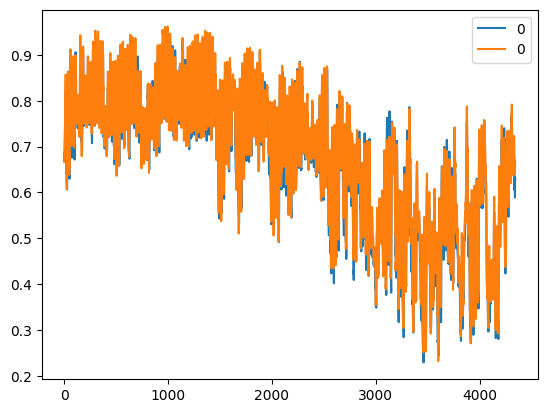

In [45]:
pd.concat((orig.iloc[:, 0], pred.iloc[:, 0]), axis=1).plot()

<AxesSubplot: >

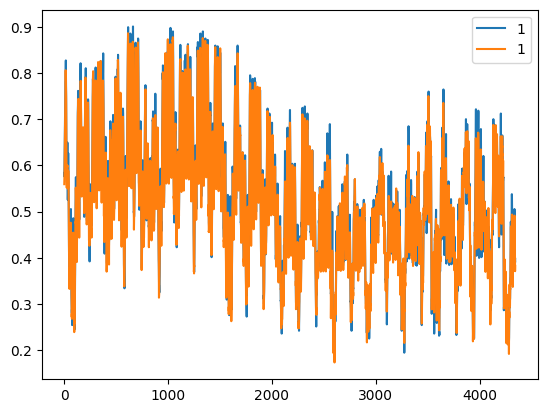

In [46]:
pd.concat((orig.iloc[:, 1], pred.iloc[:, 1]), axis=1).plot()

<AxesSubplot: >

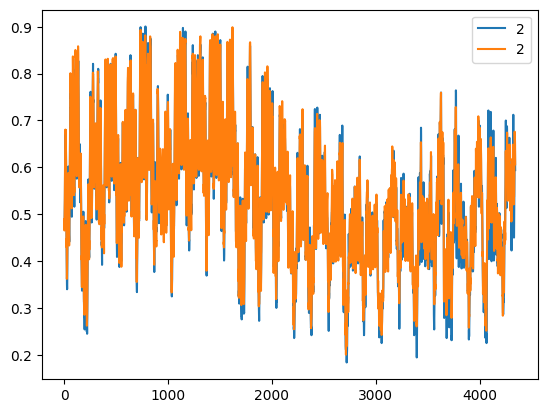

In [47]:
pd.concat((orig.iloc[:, 2], pred.iloc[:, 2]), axis=1).plot()

In [48]:
mape(orig.iloc[:, 0], pred.iloc[:, 0])

2.874870225787163

In [49]:
mape(orig.iloc[:, 1], pred.iloc[:, 1])

2.010459266602993

In [50]:
mape(orig.iloc[:, 2], pred.iloc[:, 2])

2.240876480937004

In [51]:
print("Saving the best trained models.")

# Saving the models
torch.save(best_vae_lstm_model_1, f"vae_models/L5_best_zone_1.pth")

print("Saved !")

Saving the best trained models.
Saved !


In [52]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}